In [ ]:
# import re
# from collections import Counter
# import numpy as np
# import pandas as pd
# import os
# from itertools import chain
# from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
# import torch

# # ----------------------- Config ------------------------------------------------
# W_COMP = 0.4  # Completeness
# W_DUR  = 0.3  # Duration validity
# W_FLOW = 0.3  # Task flow logic

# MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# # ----------------------- Regex Patterns ----------------------------------------
# LOCATION_PAT = r'\b(basement|ground\s*floor|gf|first\s*floor|1f|1st|second\s*floor|2f|2nd|third\s*floor|3f|3rd|floor\s*\d+|level\s*\d+|lvl\s*\d+)\b'
# ELEMENT_PAT = r'\b(slab|column|beam|footing|foundation|wall|stair(case)?|pile|pilecap|plinth)\b'
# ACTION_PAT   = r'\b(shuttering|formwork|reinforcement|rebar|concreting|pour(ing)?|curing|scaffolding|layout|setting\s*out|erection|fixing|installation)\b'

# # ----------------------- Action Benchmarks (for duration) ----------------------
# ACTION_DURATION_BENCHMARKS = {
#     'shuttering': (8, 48),
#     'formwork': (8, 48),
#     'reinforcement': (8, 72),
#     'rebar': (8, 72),
#     'concreting': (4, 24),
#     'pouring': (4, 24),
#     'curing': (72, 168),
#     'scaffolding': (8, 24),
#     'layout': (4, 16),
#     'setting out': (4, 16),
#     'erection': (8, 48),
#     'fixing': (4, 24),
#     'installation': (8, 48)
# }

# # ----------------------- LLM Initialization ------------------------------------
# tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
# model = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(DEVICE)
# llm_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, device=DEVICE, max_new_tokens=1000, temperature=0.3)

# # ----------------------- Normalization and Extraction --------------------------
# def normalize_task(task: str) -> str:
#     duration_match = re.search(r'\[?duration[:\-]?\s*\d+\s*(?:h|hr|hrs|hour|hours)?\.?\]?', task.lower())
#     duration_str = duration_match.group(0) if duration_match else ""
#     task = re.sub(r'\d+\.\s*|[\(\)]', '', task)
#     task = re.sub(r'[^\w\s/-]', ' ', task.lower())
#     task = re.sub(r'\s+', ' ', task).strip()
#     if duration_str and duration_str not in task:
#         task += f' {duration_str}'
#     return task.strip()

# def extract_duration(task: str) -> float:
#     match = re.search(r'duration[:\-]?\s*(\d+)\s*(h|hr|hrs|hour|hours)?', task.lower())
#     return float(match.group(1)) if match else None

# def get_action(task: str) -> str:
#     for action in ACTION_DURATION_BENCHMARKS:
#         if action in task:
#             return action
#     return None

# # ----------------------- GAO Practice 1: Completeness ---------------------------
# def completeness_score(tasks):
#     scores = []
#     counts = Counter({'location':0, 'element':0, 'action':0})
#     for t in tasks:
#         loc = bool(re.search(LOCATION_PAT, t))
#         ele = bool(re.search(ELEMENT_PAT, t))
#         act = bool(re.search(ACTION_PAT, t))
#         score = (0.4*loc + 0.3*ele + 0.3*act)
#         scores.append(score)
#         counts['location'] += loc
#         counts['element'] += ele
#         counts['action'] += act
#     avg_score = np.mean(scores)
#     return avg_score, counts

# # ----------------------- GAO Practice 2: Sequencing -----------------------------
# def infer_logical_order(tasks):
#     flow_order = ['layout', 'shuttering', 'formwork', 'reinforcement', 'concreting', 'curing']
#     task_order = [get_action(t) for t in tasks]
#     indices = [flow_order.index(act) for act in task_order if act in flow_order]
#     return 1.0 if all(earlier <= later for earlier, later in zip(indices, indices[1:])) else 0.0

# def dangling_task_score(tasks):
#     seq_actions = set(ACTION_DURATION_BENCHMARKS.keys())
#     return sum(any(action in t for action in seq_actions) for t in tasks) / max(1, len(tasks))

# def sequencing_score(tasks):
#     return (infer_logical_order(tasks) + dangling_task_score(tasks)) / 2

# # ----------------------- GAO Practice 4: Duration Check -------------------------
# def duration_score(tasks):
#     valid = []
#     for t in tasks:
#         dur = extract_duration(t)
#         if dur is None or dur <= 0:
#             continue
#         if 1 <= dur <= 240:
#             valid.append(1.0)
#         elif dur > 240:
#             valid.append(0.5)
#         else:
#             valid.append(0.0)
#     return np.mean(valid) if valid else 0.0

# # ----------------------- Main Ranking ------------------------------------------
# def rank_schedules():
#     schedule_files = [f for f in os.listdir() if f.endswith('.txt')]
#     if len(schedule_files) < 2:
#         print("Need at least two .txt schedule files.")
#         return

#     schedule_type = input("\nEnter schedule type (e.g., slab, column): ").strip().lower() or "slab"
#     schedules = {}
#     for fname in schedule_files:
#         with open(fname, 'r', encoding='utf-8') as f:
#             schedules[fname] = [normalize_task(line) for line in f if line.strip()]

#     print("\n✅ Using the following fixed reference schedule:")
#     reference = [
#         f"ground floor {schedule_type} layout marking",
#         f"ground floor {schedule_type} shuttering",
#         f"ground floor {schedule_type} reinforcement",
#         f"ground floor {schedule_type} concreting",
#         f"ground floor {schedule_type} curing",
#         f"first floor {schedule_type} layout marking",
#         f"first floor {schedule_type} shuttering",
#         f"first floor {schedule_type} reinforcement",
#         f"first floor {schedule_type} concreting",
#         f"first floor {schedule_type} curing"
#     ]
#     for i, task in enumerate(reference, 1):
#         print(f"{i}. {task}")

#     results = []
#     for name, tasks in schedules.items():
#         comp_score, _ = completeness_score(tasks)
#         dur_score = duration_score(tasks)
#         flow_score = sequencing_score(tasks)
#         total = W_COMP * comp_score + W_DUR * dur_score + W_FLOW * flow_score

#         results.append({
#             'Schedule': name,
#             'Completeness': round(comp_score, 3),
#             'DurationScore': round(dur_score, 3),
#             'FlowScore': round(flow_score, 3),
#             'FinalRank': round(total, 3),
#             'Tasks': len(tasks)
#         })

#     df = pd.DataFrame(results).sort_values('FinalRank', ascending=False)
#     print("\n📊 === GAO-Based Schedule Ranking (No SeqSim) ===")
#     print(df.to_string(index=False))

# # ----------------------- Run ----------------------------------------------------
# if __name__ == "__main__":
#     rank_schedules()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0



✅ Learned schedule type: slab
✅ Learned floors (in order): basement, ground floor, first floor, second floor, third floor
✅ Learned action flow: shuttering → concreting → scaffolding → installation

📌 Inferred Reference Schedule:
1. basement slab shuttering
2. basement slab concreting
3. basement slab scaffolding
4. basement slab installation
5. ground floor slab shuttering
6. ground floor slab concreting
7. ground floor slab scaffolding
8. ground floor slab installation
9. first floor slab shuttering
10. first floor slab concreting
11. first floor slab scaffolding
12. first floor slab installation
13. second floor slab shuttering
14. second floor slab concreting
15. second floor slab scaffolding
16. second floor slab installation
17. third floor slab shuttering
18. third floor slab concreting
19. third floor slab scaffolding
20. third floor slab installation

📊 === GAO-Based Schedule Ranking (Learned Reference) ===
                     Schedule  Tasks  Completeness  DurationScore  Fl

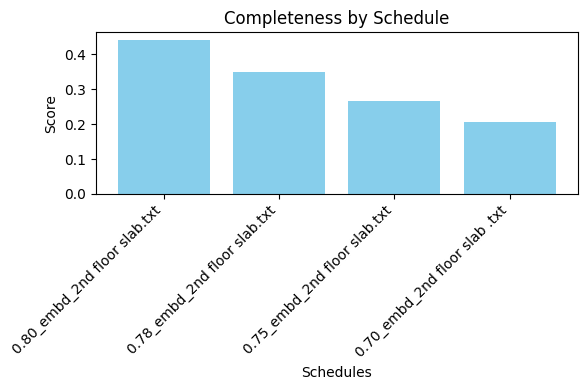

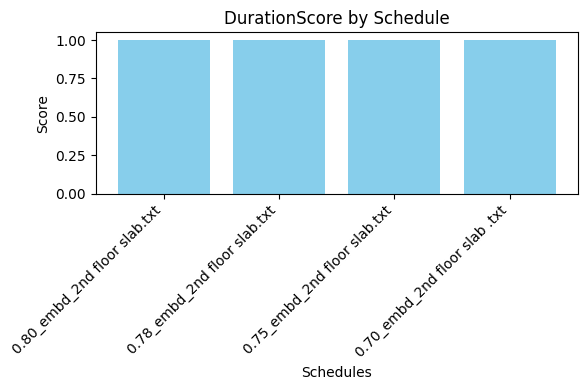

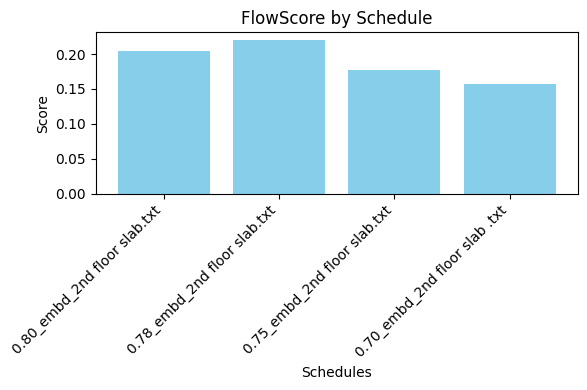

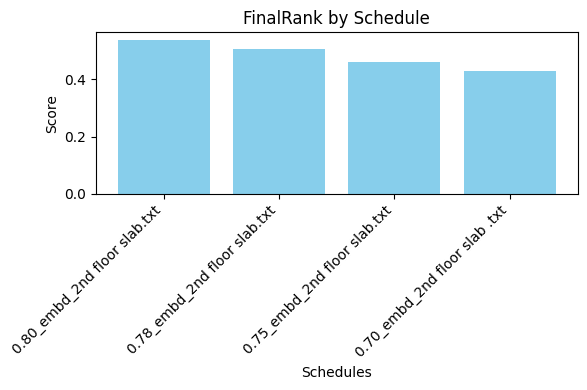

In [ ]:
import re
from collections import Counter, defaultdict, deque
import numpy as np
import pandas as pd
import os
from itertools import combinations
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import torch
import matplotlib.pyplot as plt

# ----------------------- Config ------------------------------------------------
W_COMP = 0.4  # Completeness
W_DUR  = 0.3  # Duration validity
W_FLOW = 0.3  # Task flow logic

MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# transformers pipeline wants an int device index or -1 (cpu)
_DEVICE_INDEX = 0 if torch.cuda.is_available() else -1

threshold = 0.6
# ----------------------- Regex Patterns ----------------------------------------
LOCATION_PAT = r'\b(basement|ground\s*floor|gf|first\s*floor|1f|1st|second\s*floor|2f|2nd|third\s*floor|3f|3rd|floor\s*\d+|level\s*\d+|lvl\s*\d+)\b'
ELEMENT_PAT  = r'\b(slab|column|beam|footing|foundation|wall|stair(?:case)?|pile|pilecap|plinth)\b'
ACTION_PAT   = r'\b(shuttering|formwork|reinforcement|rebar|concreting|pour(?:ing)?|curing|scaffolding|layout|setting\s*out|erection|fixing|installation)\b'

# Canonical names map for locations (for consistency)
_LOCATION_CANON = {
    "basement": "basement",
    "ground floor": "ground floor",
    "gf": "ground floor",
    "first floor": "first floor",
    "1f": "first floor",
    "1st": "first floor",
    "second floor": "second floor",
    "2f": "second floor",
    "2nd": "second floor",
    "third floor": "third floor",
    "3f": "third floor",
    "3rd": "third floor"
}

# Order of floors (for sorting learned floors in reference)
_FLOOR_SORT_KEY = {
    "basement": -1,
    "ground floor": 0,
    "first floor": 1,
    "second floor": 2,
    "third floor": 3
}

# ----------------------- Action Benchmarks (for duration) ----------------------
ACTION_DURATION_BENCHMARKS = {
    'shuttering': (8, 48),
    'formwork': (8, 48),
    'reinforcement': (8, 72),
    'rebar': (8, 72),
    'concreting': (4, 24),
    'pouring': (4, 24),
    'curing': (72, 168),
    'scaffolding': (8, 24),
    'layout': (4, 16),
    'setting out': (4, 16),
    'erection': (8, 48),
    'fixing': (4, 24),
    'installation': (8, 48)
}

# Reasonable default flow if learning fails
DEFAULT_FLOW = ['layout', 'shuttering', 'formwork', 'reinforcement', 'concreting', 'curing']

# ----------------------- LLM Initialization ------------------------------------
def _init_llm():
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
        model = AutoModelForCausalLM.from_pretrained(MODEL_ID)
        if _DEVICE_INDEX >= 0:
            model = model.to(f"cuda:{_DEVICE_INDEX}")
        return pipeline(
            "text-generation",
            model=model,
            tokenizer=tokenizer,
            device=_DEVICE_INDEX,
            max_new_tokens=256,
            temperature=0.2
        )
    except Exception as e:
        print(f"⚠️ Could not initialize LLM ({e}). Falling back to heuristics only.")
        return None

LLM = _init_llm()

# ----------------------- Normalization and Extraction --------------------------
def normalize_task(task: str) -> str:
    duration_match = re.search(r'\[?duration[:\-]?\s*\d+\s*(?:h|hr|hrs|hour|hours)?\.?\]?', task.lower())
    duration_str = duration_match.group(0) if duration_match else ""
    task = re.sub(r'\d+\.\s*|[\(\)]', '', task)
    task = re.sub(r'[^\w\s/-]', ' ', task.lower())
    task = re.sub(r'\s+', ' ', task).strip()
    if duration_str and duration_str not in task:
        task += f' {duration_str}'
    return task.strip()

def extract_duration(task: str):
    match = re.search(r'duration[:\-]?\s*(\d+)\s*(h|hr|hrs|hour|hours)?', task.lower())
    return float(match.group(1)) if match else None

def get_action(task: str):
    t = task.lower()
    # normalize synonyms
    if 'setting out' in t:
        return 'layout'
    if 'pouring' in t or 'pour' in t:
        return 'concreting'
    for action in ACTION_DURATION_BENCHMARKS:
        if action in t:
            # collapse synonyms to canonical keys
            if action == 'rebar':
                return 'reinforcement'
            if action == 'setting out':
                return 'layout'
            return action
    # fuzzy common terms
    if 'steel' in t and ('fix' in t or 'place' in t):
        return 'reinforcement'
    return None

def get_element(task: str):
    m = re.search(ELEMENT_PAT, task)
    return m.group(1) if m else None

def get_location(task: str):
    m = re.search(LOCATION_PAT, task)
    if not m:
        return None
    raw = m.group(1)
    raw = re.sub(r'\s+', ' ', raw.strip())
    return _LOCATION_CANON.get(raw, raw)

# ----------------------- GAO Practice 1: Completeness ---------------------------
def completeness_score(tasks):
    scores = []
    counts = Counter({'location':0, 'element':0, 'action':0})
    for t in tasks:
        loc = bool(re.search(LOCATION_PAT, t))
        ele = bool(re.search(ELEMENT_PAT, t))
        act = bool(re.search(ACTION_PAT, t)) or get_action(t) is not None
        score = (0.4*loc + 0.3*ele + 0.3*act)
        scores.append(score)
        counts['location'] += loc
        counts['element'] += ele
        counts['action'] += act
    avg_score = float(np.mean(scores)) if scores else 0.0
    return avg_score, counts

# ----------------------- GAO Practice 2: Sequencing (uses learned order) -------
def infer_logical_order(tasks, learned_flow_order):
    actions = [get_action(t) for t in tasks if get_action(t)]
    indices = [learned_flow_order.index(a) for a in actions if a in learned_flow_order]
    return 1.0 if indices and all(earlier <= later for earlier, later in zip(indices, indices[1:])) else 0.0

def dangling_task_score(tasks):
    seq_actions = set(ACTION_DURATION_BENCHMARKS.keys())
    return sum(any(action in t for action in seq_actions) or (get_action(t) is not None) for t in tasks) / max(1, len(tasks))

def sequencing_score(tasks, learned_flow_order):
    return (infer_logical_order(tasks, learned_flow_order) + dangling_task_score(tasks)) / 2

# ----------------------- GAO Practice 4: Duration Check -------------------------
def duration_score(tasks):
    valid = []
    for t in tasks:
        dur = extract_duration(t)
        if dur is None or dur <= 0:
            continue
        if 1 <= dur <= threshold * 600:
            valid.append(1.0)
        elif dur > threshold * 600:
            valid.append(0.5)
        else:
            valid.append(0.0)
    return float(np.mean(valid)) if valid else 0.0

# ----------------------- Learning utilities ------------------------------------
def _toposort_from_edges(nodes, edges, tie_break_order):
    """Kahn's algorithm with deterministic tiebreaks by tie_break_order list."""
    indeg = {n: 0 for n in nodes}
    for u, v in edges:
        indeg[v] += 1
    # use tie-break order to sort initial zeros
    tie_rank = {a: i for i, a in enumerate(tie_break_order)}
    q = deque(sorted([n for n in nodes if indeg[n] == 0], key=lambda x: tie_rank.get(x, 999)))
    out = []
    adj = defaultdict(list)
    for u, v in edges:
        adj[u].append(v)
    while q:
        u = q.popleft()
        out.append(u)
        for v in adj[u]:
            indeg[v] -= 1
            if indeg[v] == 0:
                q.append(v)
        # keep deterministic order
        q = deque(sorted(list(q), key=lambda x: tie_rank.get(x, 999)))
    # if cycle, fall back to tie_break_order filtered
    if len(out) != len(nodes):
        return [a for a in tie_break_order if a in nodes]
    return out

def learn_actions_precedence(all_tasks_lists):
    """
    Build a precedence graph from the order tasks appear in each schedule.
    We only use recognized actions (get_action) to create edges A->B where A appears before B.
    """
    edges = Counter()
    nodes = set()
    for tasks in all_tasks_lists:
        acts = [get_action(t) for t in tasks]
        acts = [a for a in acts if a]
        nodes.update(acts)
        for i in range(len(acts)):
            for j in range(i+1, len(acts)):
                if acts[i] != acts[j]:
                    edges[(acts[i], acts[j])] += 1
    # keep only dominant edges (appearing more than they are contradicted)
    # build reverse counts
    keep = set()
    for (u, v), w in edges.items():
        rev = edges.get((v, u), 0)
        if w > rev:
            keep.add((u, v))
    learned = _toposort_from_edges(list(nodes), list(keep), DEFAULT_FLOW)
    if not learned:
        learned = [a for a in DEFAULT_FLOW if a in nodes] or DEFAULT_FLOW
    return learned

def llm_order_actions(actions):
    """Ask LLM to order the actions logically. Returns a list or None on failure."""
    if not LLM or not actions:
        return None
    try:
        options = ", ".join(actions)
        prompt = (
            "You are a construction planner. Given these distinct actions that appear in slab/RC works:\n"
            f"{options}\n"
            "Return ONLY a comma-separated ordered list from first to last (no explanations), "
            "using just the provided action words, arranged in the most logical execution flow.\n"
            "Example output: layout, shuttering, reinforcement, concreting, curing"
        )
        out = LLM(prompt)[0]["generated_text"]
        # parse comma-separated tokens restricted to input set
        cand = [t.strip().lower() for t in out.splitlines()[-1].split(",")]
        cand = [c for c in cand if c in actions]
        return cand if cand else None
    except Exception:
        return None

def learn_reference_from_schedules(schedules_dict):
    """
    Learn:
      - schedule_type (most frequent element in tasks)
      - floor set (sorted)
      - action flow (precedence + LLM refinement)
    Then build a reference list [f"{floor} {type} {action}", ...]
    """
    all_tasks_lists = list(schedules_dict.values())
    all_tasks_flat = [t for tasks in all_tasks_lists for t in tasks]

    # 1) Most frequent element type
    elems = [get_element(t) for t in all_tasks_flat if get_element(t)]
    schedule_type = (Counter(elems).most_common(1)[0][0] if elems else 'slab')

    # 2) Floors seen, canonical & sorted
    floors = [get_location(t) for t in all_tasks_flat if get_location(t)]
    unique_floors = sorted(set(floors), key=lambda f: _FLOOR_SORT_KEY.get(f, 999))
    if not unique_floors:
        unique_floors = ["ground floor", "first floor"]  # sensible default

    # 3) Learn action order (precedence + optional LLM refinement)
    learned_flow = learn_actions_precedence(all_tasks_lists)
    # Optional: LLM refinement if it can do better ordering
    unique_actions = [a for a in learned_flow]  # start with learned set
    # ensure we include any actions seen but missing in learned set
    seen_actions = set()
    for tasks in all_tasks_lists:
        for t in tasks:
            a = get_action(t)
            if a:
                seen_actions.add(a)
    for a in seen_actions:
        if a not in unique_actions:
            unique_actions.append(a)
    llm_order = llm_order_actions(unique_actions)
    if llm_order and set(llm_order) == set(unique_actions):
        learned_flow = llm_order
    else:
        # If llm failed/fuzzy, ensure order is at least consistent with learned precedence
        learned_flow = [a for a in DEFAULT_FLOW if a in unique_actions] + \
                       [a for a in unique_actions if a not in DEFAULT_FLOW]

    # 4) Build reference schedule
    reference = []
    for fl in unique_floors:
        for act in learned_flow:
            reference.append(f"{fl} {schedule_type} {act}")
    return {
        "type": schedule_type,
        "floors": unique_floors,
        "actions": learned_flow,
        "reference_tasks": reference
    }

# ----------------------- Main Ranking ------------------------------------------
def rank_schedules():
    schedule_files = [f for f in os.listdir() if f.endswith('.txt')]
    if len(schedule_files) < 2:
        print("Need at least two .txt schedule files.")
        return

    schedules = {}
    for fname in schedule_files:
        with open(fname, 'r', encoding='utf-8') as f:
            schedules[fname] = [normalize_task(line) for line in f if line.strip()]

    learned = learn_reference_from_schedules(schedules)

    print("\n✅ Learned schedule type:", learned["type"])
    print("✅ Learned floors (in order):", ", ".join(learned["floors"]))
    print("✅ Learned action flow:", " → ".join(learned["actions"]))
    print("\n📌 Inferred Reference Schedule:")
    for i, task in enumerate(learned["reference_tasks"], 1):
        print(f"{i}. {task}")

    results = []
    for name, tasks in schedules.items():
        comp_score, _ = completeness_score(tasks)
        dur_score = duration_score(tasks)
        flow_score = sequencing_score(tasks, learned["actions"])
        total = W_COMP * comp_score + W_DUR * dur_score + W_FLOW * flow_score

        results.append({
            'Schedule': name,
            'Tasks': len(tasks),
            'Completeness': round(comp_score, 3),
            'DurationScore': round(dur_score, 3),
            'FlowScore': round(flow_score, 3),
            'FinalRank': round(total, 3)
        })

    df = pd.DataFrame(results).sort_values('FinalRank', ascending=False)
    print("\n📊 === GAO-Based Schedule Ranking (Learned Reference) ===")
    print(df.to_string(index=False))

# ----------------------- Main Ranking ------------------------------------------
def rank_schedules():
    schedule_files = [f for f in os.listdir() if f.endswith('.txt')]
    if len(schedule_files) < 2:
        print("Need at least two .txt schedule files.")
        return

    schedules = {}
    for fname in schedule_files:
        with open(fname, 'r', encoding='utf-8') as f:
            schedules[fname] = [normalize_task(line) for line in f if line.strip()]

    learned = learn_reference_from_schedules(schedules)

    print("\n✅ Learned schedule type:", learned["type"])
    print("✅ Learned floors (in order):", ", ".join(learned["floors"]))
    print("✅ Learned action flow:", " → ".join(learned["actions"]))
    print("\n📌 Inferred Reference Schedule:")
    for i, task in enumerate(learned["reference_tasks"], 1):
        print(f"{i}. {task}")

    results = []
    for name, tasks in schedules.items():
        comp_score, _ = completeness_score(tasks)
        dur_score = duration_score(tasks)
        flow_score = sequencing_score(tasks, learned["actions"])
        total = W_COMP * comp_score + W_DUR * dur_score + W_FLOW * flow_score

        results.append({
            'Schedule': name,
            'Tasks': len(tasks),
            'Completeness': round(comp_score, 3),
            'DurationScore': round(dur_score, 3),
            'FlowScore': round(flow_score, 3),
            'FinalRank': round(total, 3)
        })

    df = pd.DataFrame(results).sort_values('FinalRank', ascending=False)
    print("\n📊 === GAO-Based Schedule Ranking (Learned Reference) ===")
    print(df.to_string(index=False))

    # ----------------- Plot Bar Graph -----------------
        # ----------------- Separate Graphs -----------------
    metrics = ["Completeness", "DurationScore", "FlowScore", "FinalRank"]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.bar(df["Schedule"], df[metric], color="skyblue")
        plt.title(f"{metric} by Schedule")
        plt.ylabel("Score")
        plt.xlabel("Schedules")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

# ----------------------- Run ----------------------------------------------------
if __name__ == "__main__":
    rank_schedules()